In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

In [11]:
df_val = pd.read_csv("ref_pred_df_val_30k.csv", index_col=0)
df_val["old_abs_ml_errors"] = np.abs(df_val["old_ml_errors"])
df_val.sort_values(by=['old_abs_ml_errors'], inplace=True, ascending=False)
# rename column "surface_anomaly" to "surface_reconstruction"
df_val.rename(columns={"surface_anomaly": "surface_reconstruction"}, inplace=True)
df_val

,sid,fid,new_ref_energy,new_total_energy,old_ref_energy,old_total_energy,conv_errors,old_energy_preds,old_ml_errors,new_energy_preds,...,cat_class,bulk_symbols,ads_symbols,total_energy_conv_errors,old_adsorbate_energy,new_adsorbate_energy,old_abs_ml_errors,surface_reconstruction,adsorbate_dissociated,adsorbate_desorbed
12273,random460367,744,-38.654454,-547.06790,-38.355442,-546.66644,-0.299012,-15.0600,23.292942,-4.180,...,2,CN2Ca,*CHCHOH,-0.40146,-32.199057,-32.156187,23.292942,1,1,0
10968,random460367,534,-38.030283,-546.44370,-37.759087,-546.07007,-0.271197,-14.7400,23.016900,-1.692,...,2,CN2Ca,*CHCHOH,-0.37363,-32.199057,-32.156187,23.016900,1,1,0
21812,random460367,154,-37.250468,-545.66390,-36.968407,-545.27936,-0.282062,-15.3100,21.655907,-1.286,...,2,CN2Ca,*CHCHOH,-0.38454,-32.199057,-32.156187,21.655907,1,1,0
22398,random460367,213,-37.787056,-546.20050,-37.500725,-545.81170,-0.286331,-16.6900,20.813225,-2.174,...,2,CN2Ca,*CHCHOH,-0.38880,-32.199057,-32.156187,20.813225,1,1,0
15291,random1925009,281,-0.819991,-556.37195,-0.866858,-556.43396,0.046867,-17.9800,-17.117517,-3.945,...,2,RbP2Ir2,*CHOCH2OH,0.06201,-42.880276,-42.806440,17.117517,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,random2087427,281,-3.048657,-495.74857,-3.025413,-495.62677,-0.023244,-3.0250,0.000022,-1.470,...,2,Na2Ge2N2,*CCH2OH,-0.12180,-32.199057,-32.156187,0.000022,1,1,0
1491,random397025,63,-3.259266,-344.13293,-3.308579,-344.25420,0.049313,-3.3090,-0.000015,-3.592,...,2,Hf8Co2P2,*COHCHO,0.12127,-35.925740,-35.821367,0.000015,0,0,0
24585,random1309365,272,-1.911974,-364.43484,-1.921865,-364.43787,0.009891,-1.9220,-0.000010,-1.861,...,1,Cs8Ge4Te16,*CHOHCH3,0.00303,-39.153593,-39.141260,0.000010,1,0,0
15023,random1973231,134,0.686516,-611.03190,0.591314,-610.91846,0.095202,0.5913,-0.000005,0.951,...,1,Ti3Re3Si3,*NONH,-0.11344,-26.847645,-26.916733,0.000005,0,1,0


## Extract unique elements from the nonmetallic systems

In [12]:
nonmetals_elements = []
# Filtering nonmetallic systems {0: intermetallics, 1: metalloids, 2: nonmetals, 3: halides}
nonmetals_df = df_val.query("cat_class==2")  
for i in tqdm(range(len(nonmetals_df))):
    nonmetals_elements += list(np.unique(np.array(re.findall('[A-Z][a-z]?', f'{nonmetals_df.iloc[i]["bulk_symbols"]}'))))
print("There are", len(np.unique(np.array(nonmetals_elements))), "unique elements in the nonmetallic systems.")

100%|██████████| 8713/8713 [00:01<00:00, 6655.92it/s]

There are 54 unique elements in the nonmetallic systems.


## Remove duplicates and sort the elements

In [13]:
unique_nonmetals_elements = sorted(list(set(nonmetals_elements)))
bulk_element_encoding = []
for bulk in tqdm(nonmetals_df["bulk_symbols"].values):
    elements_encoding = []
    for element in unique_nonmetals_elements:
        if element in np.unique(np.array(re.findall('[A-Z][a-z]?', f'{bulk}'))):
            elements_encoding.append(1)
        else: 
            elements_encoding.append(0)
    bulk_element_encoding.append(elements_encoding)

100%|██████████| 8713/8713 [00:09<00:00, 946.13it/s]


## Make the element encoding into a dataframe and concatenate to the nonmetals dataframe

In [14]:
# Create a DataFrame from bulk_element_encoding with column names as unique_nonmetals_elements
bulk_elements_encodings_df = pd.DataFrame(bulk_element_encoding, columns=unique_nonmetals_elements)
# Reset the index of bulk_elements_encodings_df
bulk_elements_encodings_df.reset_index(drop=True, inplace=True)
# Concatenate bulk_elements_encodings_df with the existing DataFrame df
nonmetals_df = pd.concat([nonmetals_df.reset_index(drop=True), bulk_elements_encodings_df], axis=1)
nonmetals_df.iloc[:,-54:]

,Ag,Al,As,Au,Bi,C,Ca,Cd,Cl,Co,...,Ta,Tc,Te,Ti,Tl,V,W,Y,Zn,Zr
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8710,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### For each unique element, calculate the fraction of calculations with surface reconstructions and energy MAEs of each element. 

In [15]:
surf_recons_errors_dict = {}
for element in unique_nonmetals_elements:
    mae = nonmetals_df.query(f"{element}==1")["old_abs_ml_errors"].mean()
    surf_reconst = len(nonmetals_df.query(f"{element}==1&surface_reconstruction==1"))/len(nonmetals_df.query(f"{element}==1"))
    surf_recons_errors_dict[element] = {"mae": mae,  "surf_reconst" : surf_reconst}

## Make a subset for the nonmetals elements which are N, C, P, S, and Se. 

In [16]:
surf_recons_errors_dict_subset = {}
for element in ["N", "C", "P", "S", "Se"]:
    surf_recons_errors_dict_subset[element] = surf_recons_errors_dict[element]
# Sort the dictionary by ratio of surface reconstructed calculations
sorted_surf_recons_errors = sorted(surf_recons_errors_dict_subset.items(), key=lambda x: x[1]['surf_reconst'], reverse=True)
sorted_keys = [item[0] for item in sorted_surf_recons_errors]
sorted_errors = [item[1]['mae'] for item in sorted_surf_recons_errors]
sorted_surf_reconst = [item[1]['surf_reconst'] for item in sorted_surf_recons_errors]

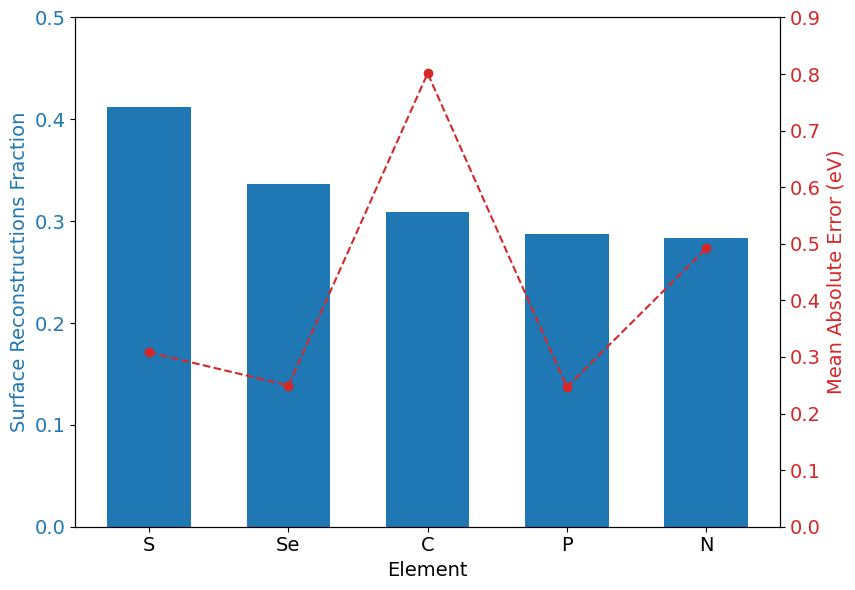

In [17]:
# Plotting the bar plot with mean errors
fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:blue' 
ax1.set_xlabel('Element', fontsize= 14)
ax1.set_ylabel('Surface Reconstructions Fraction' , color=color,fontsize= 14) 
ax1.bar(sorted_keys, sorted_surf_reconst , color=color, width = 0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='x', labelsize= 14)
ax1.tick_params(axis='y', labelsize= 14)
fig.tight_layout()  

# Create a second y-axis for element counts
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Mean Absolute Error (eV)', color=color, alpha = 1, fontsize= 14)
ax2.plot(sorted_keys, sorted_errors, color=color, linestyle='--', marker='o')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.9)
ax2.tick_params(axis='x', labelsize= 14)
ax2.tick_params(axis='y', labelsize= 14)
plt.show()